In [171]:
from nxs_analysis_tools.datareduction import *
from nxs_analysis_tools.pairdistribution import *
from nexusformat.nexus import *
import numpy as np

In [172]:
data = load_data(r'C:\Users\steve\OneDrive\Documents\UCSB\DISCUS\two_atom_alloy_3d\shortrangeafmordered_interpolated.nxs')
# data = NXdata(NXfield(data.counts.nxdata[:,:,None], name="counts"),(data.H, data.K, NXfield(np.array([0.0]), name="L")))
print(data.tree)

data:NXdata
  @axes = ['H', 'K', 'L']
  @signal = 'counts'
  H = float64(201)
  K = float64(201)
  L = float64(201)
  counts = float64(201x201x201)
data:NXdata
  @axes = ['H', 'K', 'L']
  @signal = 'counts'
  H = float64(201)
  K = float64(201)
  L = float64(201)
  counts = float64(201x201x201)


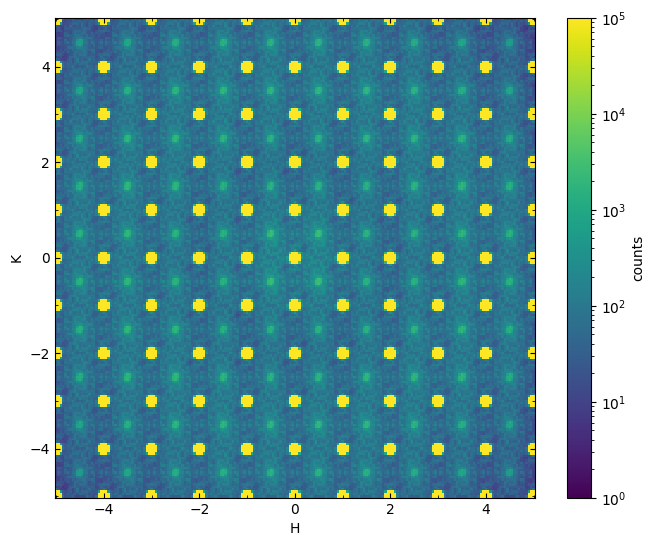

In [173]:
plot_slice(data[:,:,0.0], vmin=1, vmax=1e5, logscale=True)

# Method 1: Standard Bragg punch

In [174]:
class Puncher:
    def __init__(self):
        self.punched = None
        self.data = None
        self.HH, self.KK, self.LL = [None] * 3
        self.mask = None
        self.reciprocal_lattice_params = None
        self.lattice_params = None
        self.a, self.b, self.c, self.al, self.be, self.ga = [None] * 6
        self.a_star, self.b_star, self.c_star, self.al_star, self.be_star, self.ga_star = [None] * 6
    
    def set_data(self, data):
        self.data = data
        if self.mask is None:
            self.mask = np.zeros(data[data.signal].nxdata.shape)
        self.H, self.K, self.L = np.meshgrid(data[data.axes[0]], data[data.axes[1]], data[data.axes[2]], indexing='ij')
    
    def set_lattice_params(self, lattice_params):
        self.a, self.b, self.c, self.al, self.be, self.ga = lattice_params
        self.lattice_params = lattice_params
        self.reciprocal_lattice_params = reciprocal_lattice_params(lattice_params)
        self.a_star, self.b_star, self.c_star, self.al_star, self.be_star, self.ga_star = self.reciprocal_lattice_params

    def add_mask(self, maskaddition):
        self.mask = np.logical_or(self.mask, maskaddition)

    def punch(self):
        data= self.data
        self.punched = NXdata(NXfield(np.where(self.mask, np.nan, data[data.signal].nxdata), name=data.signal),
                              (data[data.axes[0]],data[data.axes[1]],data[data.axes[2]]))

    def generate_bragg_mask(self, punch_radius, coeffs=None, thresh=None):
        if coeffs is None:
            coeffs = [1, 0, 1, 0, 1, 0]
        data = self.data
        H, K, L = self.H, self.K, self.L
        a_, b_, c_, al_, be_, ga_ = self.reciprocal_lattice_params

        mask = (coeffs[0] * (H - np.rint(H)) ** 2 +
                coeffs[1] * (b_ * a_ / (a_ ** 2)) * (H - np.rint(H)) * (K - np.rint(K)) +
                coeffs[2] * (b_ / a_) ** 2 * (K - np.rint(K)) ** 2 +
                coeffs[3] * (b_ * c_ / (a_ ** 2)) * (K - np.rint(K)) * (L - np.rint(L)) +
                coeffs[4] * (c_ / a_) ** 2 * (L - np.rint(L)) ** 2 +
                coeffs[5] * (c_ * a_ / (a_ ** 2)) * (L - np.rint(L)) * (H - np.rint(H))) < punch_radius ** 2

        if thresh:
            mask = np.logical_and(mask, data[data.signal] > thresh)    

        return mask
    
    def generate_intensity_mask(self, thresh, radius, verbose=True):
        data = self.data
        counts = data[data.signal].nxdata
        mask = np.zeros(counts.shape)
        
        print(f"Shape of data is {counts.shape}") if verbose else None
        for i in range(counts.shape[0]):
            for j in range(counts.shape[1]):
                for k in range(counts.shape[2]):
                    if counts[i, j, k] > thresh:
                        # Set the pixels within the sphere to NaN
                        for x in range(max(i - radius, 0), min(i + radius + 1, counts.shape[0])):
                            for y in range(max(j - radius, 0), min(j + radius + 1, counts.shape[1])):
                                for z in range(max(k - radius, 0), min(k + radius + 1, counts.shape[2])):
                                    mask[x, y, z] = 1
                        print(f"Found high intensity at ({i}, {j}, {k}).\t\t", end='\r') if verbose else None
        print("\nDone.")
        return mask
    
def load_discus_nxs(path):
    filename = path
    root = nxload(filename)
    hlim,klim,llim = root.lower_limits
    hstep,kstep,lstep = root.step_sizes
    h = NXfield(np.linspace(hlim,-hlim,int(np.abs(hlim*2)/hstep)+1), name='H')
    k = NXfield(np.linspace(klim,-klim,int(np.abs(klim*2)/kstep)+1), name='K')
    l = NXfield(np.linspace(llim,-llim,int(np.abs(llim*2)/lstep)+1), name='L')
    data = NXdata(NXfield(root.data[:,:,:], name='counts'),(h,k,l))

    return data

In [181]:
import time
import os
import scipy
import pyfftw
from scipy import ndimage
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
from nexusformat.nexus import nxsave, NXroot, NXentry, NXdata, NXfield
import numpy as np
import gc
# from .datareduction import plot_slice, reciprocal_lattice_params, Padder, array_to_nxdata
from astropy.convolution import convolve, Kernel, convolve_fft
import math
def _round_up_to_odd_integer(value):
    i = int(math.ceil(value))
    if i % 2 == 0:
        return i + 1
    else:
        return i


class Gaussian3DKernel(Kernel):
    _separable = True
    _is_bool = False

    def __init__(self, stddev, size, coeffs=None, **kwargs):
        if not coeffs:
            coeffs=[1,0,1,0,1,0]
        x_dim, y_dim, z_dim = size
        x = np.linspace(-x_dim, x_dim, int(x_dim) + 1)
        y = np.linspace(-y_dim, y_dim, int(y_dim) + 1)
        z = np.linspace(-z_dim, z_dim, int(z_dim) + 1)
        X, Y, Z = np.meshgrid(x, y, z)
        array = np.exp(-(coeffs[0] * X ** 2 +
                         coeffs[1] * X * Y +
                         coeffs[2] * Y ** 2 +
                         coeffs[3] * Y * Z +
                         coeffs[4] * Z ** 2 +
                         coeffs[5] * Z * X) / (2 * stddev ** 2)
                       )
        self._default_size = _round_up_to_odd_integer(stddev)
        super(Gaussian3DKernel, self).__init__(array)
        self.normalize()
        self._truncation = np.abs(1. - self._array.sum())
        
class Interpolator():
    def __init__(self):
        self.interpolated = None
        self.data = None

    def set_data(self, data):
        self.data = data

    def set_kernel(self, kernel):
        self.kernel = kernel

    def interpolate(self):
        start = time.time()

        try:
            print("Last interpolation took {:.2f} minutes.".format(interp_time / 60))
        except:
            pass

        print("Running interpolation...")
        result = np.real(convolve_fft(self.data[self.data.signal].nxdata, self.kernel, allow_huge=True, return_fft=False))
        print("Interpolation finished.")

        end = time.time()
        interp_time = end - start

        print('Interpolation took {:.2f} minutes.'.format(interp_time / 60))

        result[result < 0] = 0
        self.interpolated = array_to_nxdata(result, self.data)

    def set_tukey_window(self, tukey_alphas=(1.0,1.0,1.0)):
        data = self.data
        tukey_H = np.tile(scipy.signal.tukey(len(data[data.axes[0]]), alpha=tukey_alphas[0])[:,None,None], (1,len(data[data.axes[1]]),len(data[data.axes[2]])))
        tukey_K = np.tile(scipy.signal.tukey(len(data[data.axes[1]]),alpha=tukey_alphas[1])[None,:,None], (len(data[data.axes[0]]),1,len(data[data.axes[2]])))
        window = tukey_H*tukey_K

        del tukey_H,tukey_K
        gc.collect()

        tukey_L = np.tile(scipy.signal.tukey(len(data[data.axes[2]]),alpha=tukey_alphas[2])[None,None,:], (len(data[data.axes[0]]),len(data[data.axes[1]]),1))
        window = window*tukey_L
        
        self.window = window

    def set_hexagonal_tukey_window(self, tukey_alphas=(1.0,1.0,1.0,1.0)):
        data = self.data
        H_ = data[data.axes[0]]
        K_ = data[data.axes[1]]
        L_ = data[data.axes[2]]
        
        tukey_H = np.tile(scipy.signal.tukey(len(data[data.axes[0]]), alpha=tukey_alphas[0])[:,None,None], (1,len(data[data.axes[1]]),len(data[data.axes[2]])))
        tukey_K = np.tile(scipy.signal.tukey(len(data[data.axes[1]]),alpha=tukey_alphas[1])[None,:,None], (len(data[data.axes[0]]),1,len(data[data.axes[2]])))
        window = tukey_H*tukey_K

        del tukey_H,tukey_K
        gc.collect()
        
        truncation = int((len(H_)-int(len(H_)*np.sqrt(2)/2))/2)

        tukey_HK = scipy.ndimage.rotate(
                        np.tile(
                            np.concatenate(
                                (np.zeros(truncation)[:,None,None],
                                 scipy.signal.tukey(len(H_)-2*truncation,
                                                    alpha=tukey_alphas[2])[:,None,None],
                                 np.zeros(truncation)[:,None,None])),
                            (1,len(K_),len(L_))
                        ),
                        angle=45, reshape=False, mode='nearest',
                    )[0:len(H_),0:len(K_),:]
        tukey_HK = np.nan_to_num(tukey_HK)
        window = window*tukey_HK
        
        del tukey_HK
        gc.collect()

        tukey_L = np.tile(scipy.signal.tukey(len(data[data.axes[2]]),alpha=tukey_alphas[3])[None,None,:], (len(data[data.axes[0]]),len(data[data.axes[1]]),1))
        window = window*tukey_L
        
        del tukey_L
        gc.collect()
        
        self.window=window
    
    def set_window(self, window):
        self.window = window
    
    def apply_window(self):
        self.tapered = self.interpolated*self.window

def fourier_transform_nxdata(data):
    start=time.time()
    print("Starting FFT.")
    
    padded = data[data.signal].nxdata
    
    fft_array = np.zeros(padded.shape)
    print("FFT on axes 1,2")
    for k in range(0,padded.shape[2]):
        fft_array[:,:,k] = np.real(np.fft.fftshift(pyfftw.interfaces.numpy_fft.ifftn(np.fft.fftshift(padded[:,:,k]), planner_effort='FFTW_MEASURE')))
        print(f'k={k}                  ', end='\r')

    print("FFT on axis 3")
    for i in range(0,padded.shape[0]):
        for j in range(0,padded.shape[1]):
            f_slice = fft_array[i,j,:]
            print(f'i={i}                  ', end='\r')
            fft_array[i,j,:] = np.real(np.fft.fftshift(pyfftw.interfaces.numpy_fft.ifftn(np.fft.fftshift(f_slice), planner_effort='FFTW_MEASURE')))

    end=time.time()
    print("FFT complete.")
    print('FFT took '+str(end-start)+' seconds.')
    
    H_step = data[data.axes[0]].nxdata[1]-data[data.axes[0]].nxdata[0]
    K_step = data[data.axes[1]].nxdata[1]-data[data.axes[1]].nxdata[0]
    L_step = data[data.axes[2]].nxdata[1]-data[data.axes[2]].nxdata[0]
    
    fft = NXdata(NXfield(fft_array,name='dPDF'),
                          [NXfield(np.linspace(-0.5/H_step,0.5/H_step,padded.shape[0]),name='x'),
                           NXfield(np.linspace(-0.5/K_step,0.5/K_step,padded.shape[1]),name='y'),
                           NXfield(np.linspace(-0.5/L_step,0.5/L_step,padded.shape[1]),name='z'),
                          ])
    return fft

class DeltaPDF():
    
    def __init__(self):
        self.data = None 
        self.lattice_params = None
        self.puncher = Puncher()
        self.interpolator = Interpolator()
        self.padder = Padder()
        self.mask = None
        self.kernel = None
        self.window = None
        self.padded = None
        self.tapered = None
        self.interpolated = None
        self.punched = None
    
    def set_data(self, data):
        self.data = data
        self.puncher.set_data(data)
        self.interpolator.set_data(data)
        
    def set_lattice_params(self, lattice_params):
        self.lattice_params = lattice_params
        self.puncher.set_lattice_params(lattice_params)
    
    def add_mask(self,maskaddition):
        self.puncher.add_mask(maskaddition)
        self.mask = self.puncher.mask
    
    def subtract_mask(self,masksubtraction):
        self.puncher.subtract_mask(masksubtraction)
        self.mask = self.puncher.mask
    
    def generate_bragg_mask(self, punch_radius, coeffs=None, thresh=None):
        return self.puncher.generate_bragg_mask(punch_radius, coeffs, thresh)
        
    def generate_intensity_mask(self, thresh, radius, verbose=True):
        return self.puncher.generate_intensity_mask(thresh, radius, verbose)

    def generate_mask_at_coord(self, coordinate, punch_radius, coeffs=None, thresh=None):
        return self.puncher.generate_mask_at_coord(coordinate, punch_radius, coeffs, thresh)
    
    def punch(self):
        self.puncher.punch()
        self.punched = self.puncher.punched
        self.interpolator.set_data(self.punched)
        
    def set_kernel(self, kernel):
        self.interpolator.set_kernel(kernel)
        self.kernel = kernel
    
    def interpolate(self):
        self.interpolator.interpolate()
        self.interpolated = self.interpolator.interpolated
        
    def set_tukey_window(self, tukey_alphas=(1.0,1.0,1.0)):
        self.interpolator.set_tukey_window(tukey_alphas)
        self.window = self.interpolator.window
        
    def set_hexagonal_tukey_window(self, tukey_alphas=(1.0,1.0,1.0,1.0)):
        self.interpolator.set_hexagonal_tukey_window(tukey_alphas)
        
    def set_window(self, window):
        self.interpolator.set_window(window)
    
    def apply_window(self):
        self.interpolator.apply_window()
        self.tapered = self.interpolator.tapered
        self.padder.set_data(self.tapered)
    
    def pad(self, padding):
        self.padded = self.padder.pad(padding)
        
    def fft(self):
        self.fft = fourier_transform_nxdata(self.padded)        

In [182]:
p = DeltaPDF()

In [183]:
p.set_data(data)

In [184]:
p.set_lattice_params((5,5,5,90,90,90))

In [186]:
mask = p.generate_bragg_mask(punch_radius=0.2)

In [187]:
p.add_mask(mask)

In [188]:
p.punch()

In [189]:
p.set_kernel(Gaussian3DKernel(stddev=1, size=(10,10,10)))

In [190]:
p.interpolate()

Running interpolation...
Interpolation finished.
Interpolation took 0.15 minutes.


In [192]:
p.set_tukey_window()

In [193]:
p.apply_window()

In [194]:
p.pad(padding=(20,20,20))

In [195]:
p.fft()

Starting FFT.
FFT on axes 1,2
FFT on axis 3          
FFT complete.          
FFT took 36.16149687767029 seconds.


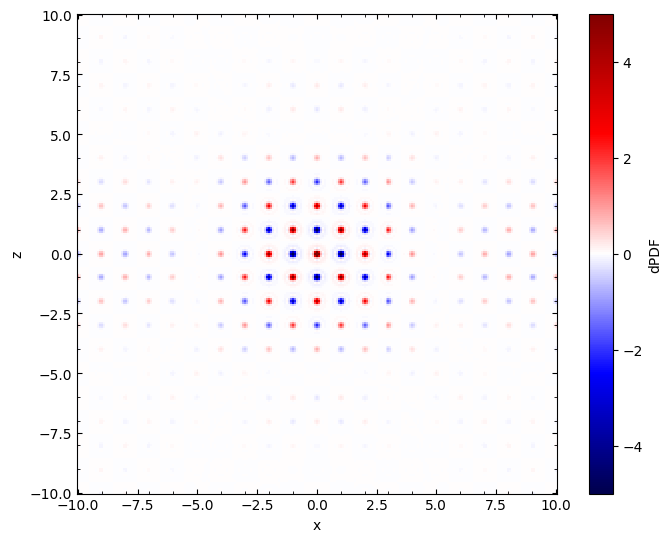

In [197]:
plot_slice(p.fft[:,0.0,:]/10, cmap='seismic' 
           vmin=-5, vmax=5)